# Convolutional Neural Network Archictures

## What's new?
- This is the first notebook where we implement a CNN(convolutional neural network) using Keras (with TensorFlow2 back-end.
- Discussion on popular CNN architechtures like AlexNet, LeNet,  GoogLeNet, Inception, ResNet etc


## Reference
- The project follows the suggestions from Chapter 14 of “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly). Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.”   
- - As always, we are skipping the mathematical justification behind each strategy and instead focus on implementation. The book mentioned above has excellent references (mostly publications where these results are published). So if you feel like you need the mathematical reasoning behind any of the strategies, I would strongly encourage taking a look at these references.

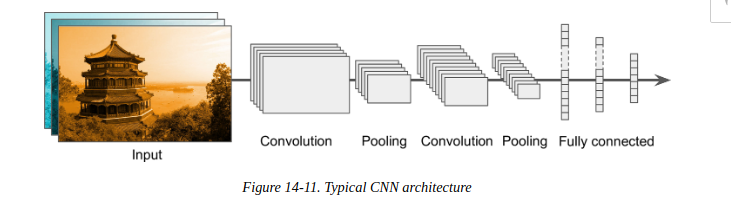

## Importing dependencies

In [1]:

import sys
assert sys.version_info >= (3, 5)

# TensorFLow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

#import Keras
from tensorflow import keras

# Common imports
import numpy as np
import pandas as pd
import os

# importing matplotlib for plotting and figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_figure(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Loading data 

### Keras to load dataset.
We load the fashion MNIST dataset. (70,000) grayscale images of 28x28 pixels 
with 10 classes:  
["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

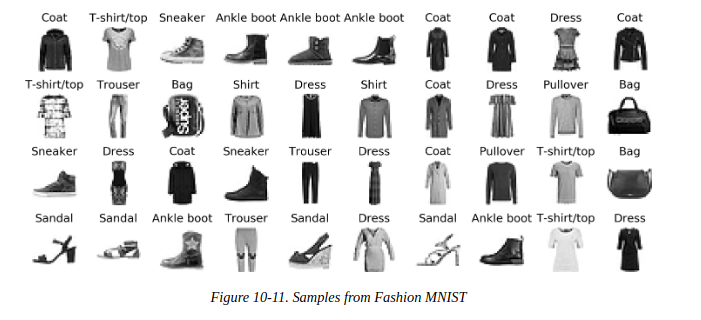

In [2]:
fashion_mnist_ds = keras.datasets.fashion_mnist
#Separating training set and test set
(X_train_full, Y_train_full),(X_test_set, Y_test_set) = \
                                        fashion_mnist_ds.load_data()

In [3]:
print("type of X_train_full: ", type(X_train_full))
#60,000 instances of 28x28 pixels. Each pixel is rep by int between
#0 and 255
print("X_train_full shape: ",X_train_full.shape)

type of X_train_full:  <class 'numpy.ndarray'>
X_train_full shape:  (60000, 28, 28)


##### Creating a validation set and also scaling data so value lies between 0 an 1, also take care of converting data type to float

In [4]:
X_validtn, Y_validtn = X_train_full[:5000]/255.0, Y_train_full[:5000]
X_train, Y_train = X_train_full[5000:]/255.0, Y_train_full[5000:]
X_test_set = X_test_set/255.0

#Adding class labels
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Creating CNN using Keras layers

- Common mistake:  using  convolution kernels that are too large. For example, instead of using a convolutional layer with a 5 × 5 kernel, stack two layers with 3 × 3 kernels: it will use fewer parameters and require fewer computations, and it will usually perform better.
- One exception is for the first convolutional layer: it can typically have a large kernel (e.g., 5 × 5), usually with a stride of 2 or more: this will reduce the spatial dimension of the image without losing too much information, and since the input image only has three channels in general, it will not be too costly.

### Simple CNN using Keras sequential api

In [5]:
cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
                        input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

#### Explanation of the cnn architecture:
- The first layer uses 64 fairly large filters (7 × 7) but only stride 1 because the input images are not very large. It also sets input_shape=[28, 28, 1], because the images are 28 × 28 pixels, with a single color channel (i.e., grayscale).

- Next we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.

- Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter you can tune).

- Note that the number of filters grows as we climb up the CNN toward the output layer (it is initially 64, then 128, then 256): it makes sense for it to grow, since the number of low-level features is often fairly low (e.g., small circles, horizontal lines), but there are many different ways to combine them into higher-level features. It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear of exploding the number of parameters, memory usage, or computational load.

- Next is the fully connected network, composed of two hidden dense layers and a dense output layer. Note that we must flatten its inputs, since a dense network expects a 1D array of features for each instance. We also add two dropout layers, with a dropout rate of 50% each, to reduce overfitting.

#### Getting summary of the model

In [7]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

#### Accessing and changing parameters of the layers. 
This can be done using `get_weights()` and `set_weights()`.   
Hidden layers have both connection weights and biases(per neuron in the layer)
as layer parameters

## Popular CNN models

### LeNet-5 Architecture

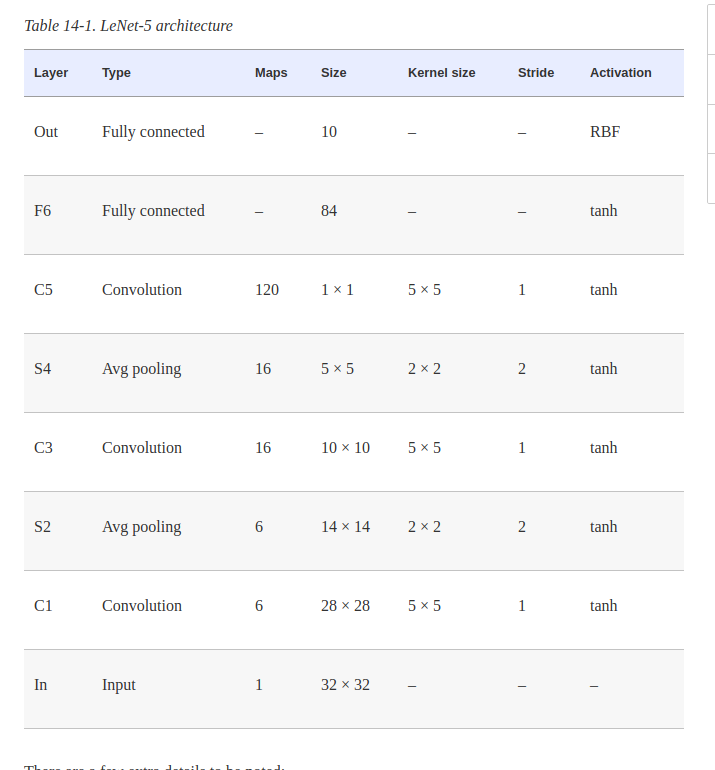

### AlexNet

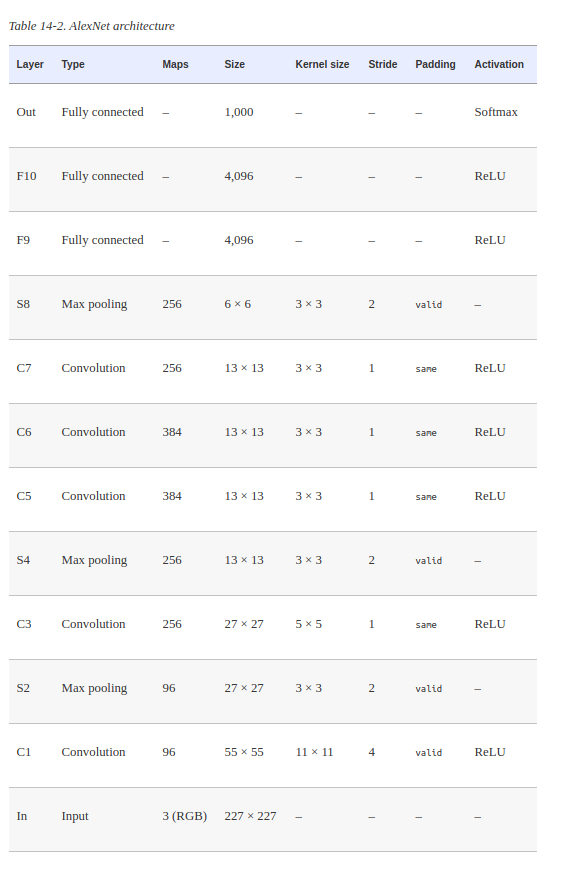

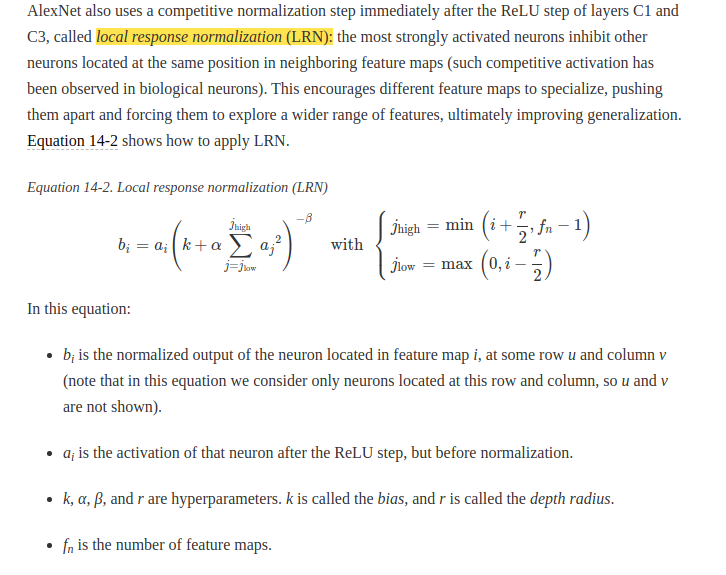

### Google Net

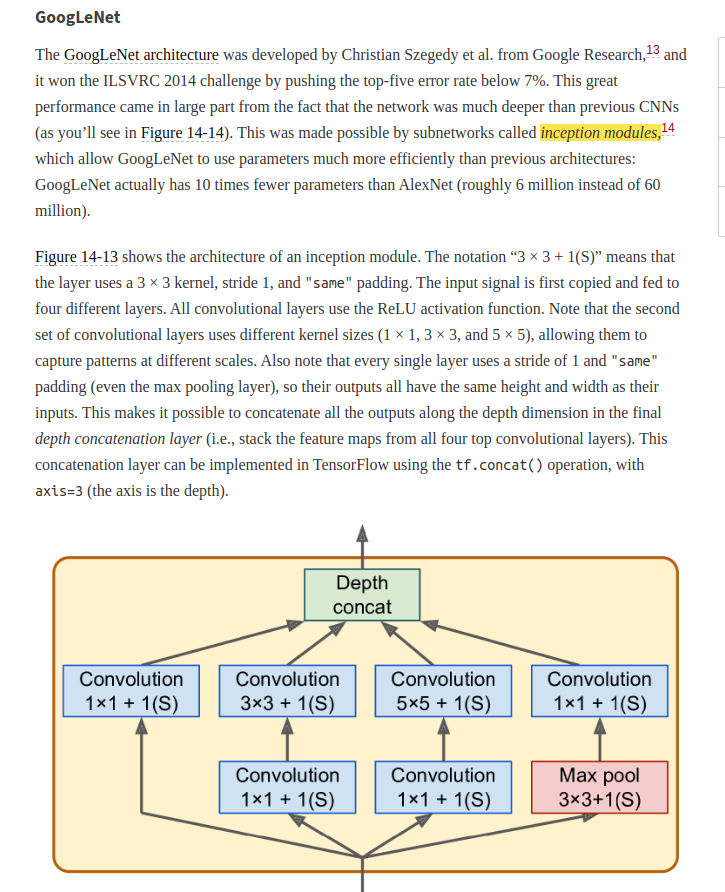

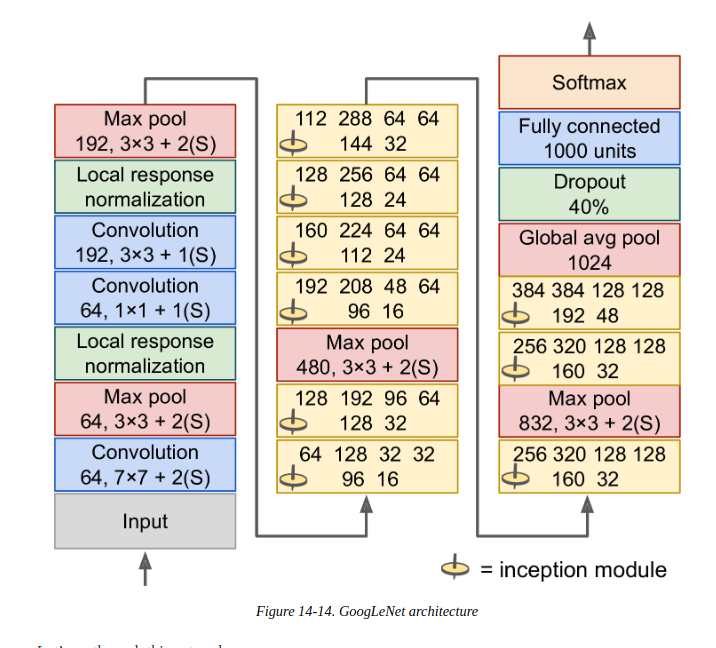

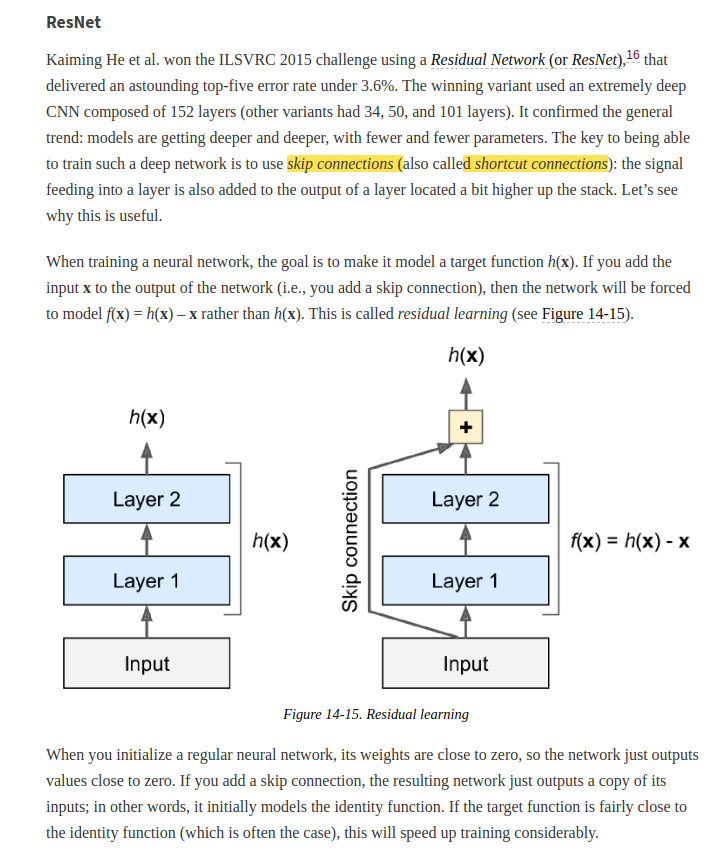

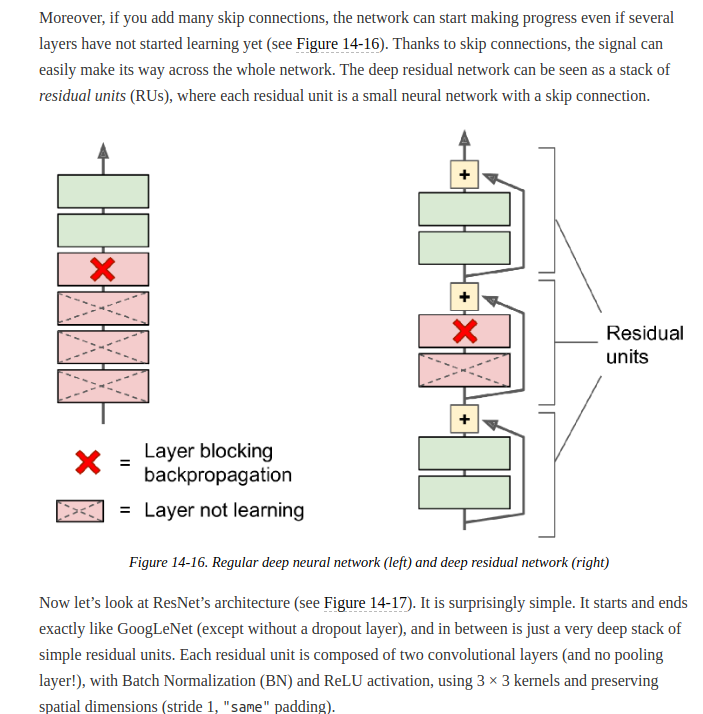

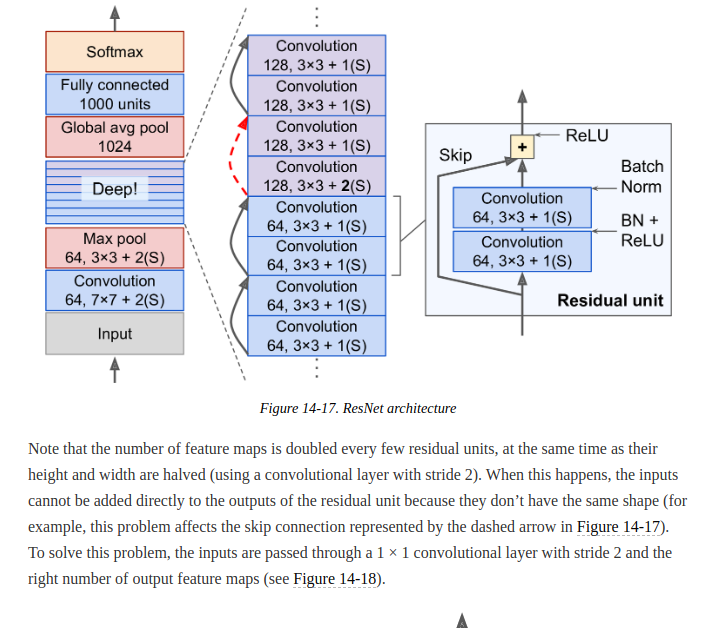

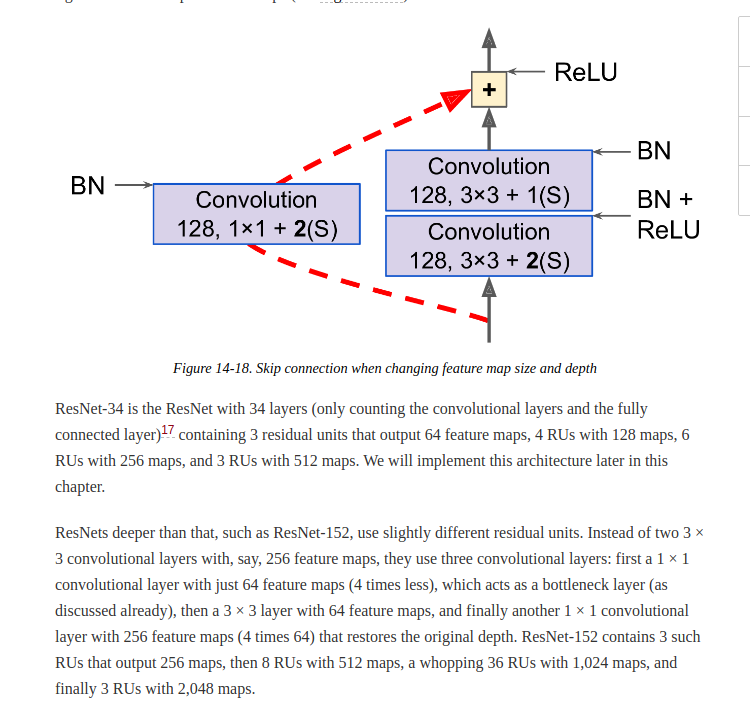

### SENet

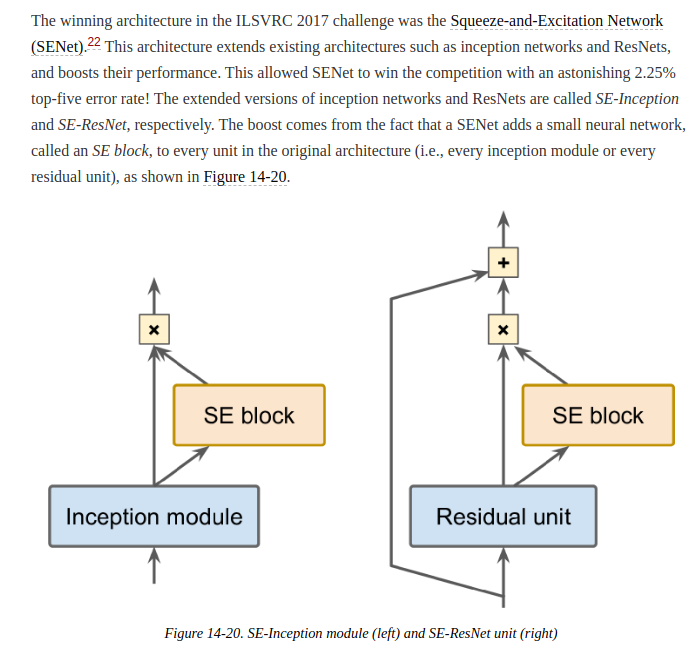